# Overview
This is a simple end to end example of how you can use SAS Viya for analysis
The example follows these steps:
1. Importing the needed Python packages
1. Starting a CAS session on an already running CAS server
1. Load the needed CAS Action Sets
1. Loading data from the local file system to the CAS server
1. Explore the data
1. Impute missing values
1. Partition the data into training and validation partitions
1. Build a decision tree
1. Build a neural network
1. Build a decision forest
1. Build a gradient boost
1. Assess the models
1. Build ROC charts

## Set up and initialize

Find doc for all the CAS actions [here](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg&docsetTarget=titlepage.htm 
) 

### Documentation Links:
* [SAS® Viya™ 3.2: System Programming Guide](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg&docsetTarget=titlepage.htm)
* [Getting Started with SAS® Viya™ 3.2 for Python](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3&docsetTarget=titlepage.htm&locale=en)

In this code we import the needed packages and we assign variables for the modeling details that will be used later in the analysis

In [1]:
import os
import pandas as pd
import swat
import sys
from matplotlib import pyplot as plt
import getpass
%matplotlib inline

target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

indata = 'hmeq'

## Start CAS session

* Documentation to [Connect and Start a Session](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3&docsetTarget=home.htm&locale=en)

In this code we assign values for the cashost, casport, and casauth values. These are then used to establish a CAS session named `sess`.

In [5]:
import swat

os.environ["CAS_CLIENT_SSL_CA_LIST"] = "/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem"

# type password
password = getpass.getpass()

# Connect to CAS server
#s = swat.CAS('frasepviya35smp', 5570, 'viyademo01', password)

cashost='frasepviya35smp'
casport=5570
sess = swat.CAS(cashost, casport)

# Load the needed action sets for this example:
sess.loadactionset('datastep')
sess.loadactionset('datapreprocess')
sess.loadactionset('cardinality')
sess.loadactionset('sampling')
sess.loadactionset('regression')
sess.loadactionset('decisiontree')
sess.loadactionset('neuralnet')
sess.loadactionset('svm')
sess.loadactionset('astore')
sess.loadactionset('percentile')

 ······


NOTE: Added action set 'datastep'.
NOTE: Added action set 'datapreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisiontree'.
NOTE: Added action set 'neuralnet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000445s, user: 0.000223s, sys: 0.000166s, mem: 0.203mb

## Access data cataloged in CAS



In [8]:
#indata = sess.CASTable('hmeq')
#if not indata.tableexists().exists:
#    indata = sess.upload_file('http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv', casout=indata)

# Déclaration de la table CAS déjà chargée en mémoire et accessible par les utilisateurs Python/SAS/R
indata = sess.CASTable('HMEQ_TRAIN', caslib='PUBLIC')

## Explore and Impute missing values

In [9]:
indata.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,BAD,0.000000,1.000000,2381.0,0.0,0.199916,4.760000e+02,0.400021,0.008198,1.600168e-01,4.760000e+02,3.808400e+02,200.094538,24.386219,1.966986e-117,1.501603,0.255024
1,LOAN,1300.000000,89000.000000,2381.0,0.0,18216.463671,4.337340e+07,10669.354029,218.654504,1.138351e+08,1.061038e+12,2.709276e+11,58.569842,83.311632,0.000000e+00,1.890252,6.174110
2,MORTDUE,2619.000000,369874.000000,2178.0,203.0,73888.350849,1.609288e+08,43967.539209,942.113489,1.933145e+09,1.609922e+13,4.208456e+12,59.505374,78.428291,0.000000e+00,1.602092,4.773814
3,VALUE,9100.000000,855909.000000,2339.0,42.0,102594.821005,2.399693e+08,58102.560140,1201.379337,3.375907e+09,3.251248e+13,7.892872e+12,56.633034,85.397524,0.000000e+00,3.160516,26.586591
4,YOJ,0.000000,41.000000,2184.0,197.0,8.851671,1.933205e+04,7.520705,0.160928,5.656100e+01,2.945936e+05,1.234727e+05,84.963673,55.003844,0.000000e+00,0.991435,0.384783
5,DEROG,0.000000,10.000000,2105.0,276.0,0.230404,4.850000e+02,0.754975,0.016455,5.699877e-01,1.311000e+03,1.199254e+03,327.674851,14.001770,1.173412e-42,5.680540,46.436541
6,DELINQ,0.000000,10.000000,2153.0,228.0,0.449141,9.670000e+02,1.094231,0.023582,1.197342e+00,3.011000e+03,2.576681e+03,243.627743,19.045627,7.298053e-75,3.427232,14.287922
7,CLAGE,0.000000,1168.233561,2255.0,126.0,178.606762,4.027582e+05,85.735499,1.805458,7.350576e+03,8.850354e+07,1.656820e+07,48.002381,98.926010,0.000000e+00,1.436678,9.263203
8,NINQ,0.000000,14.000000,2189.0,192.0,1.172225,2.566000e+03,1.721473,0.036794,2.963469e+00,9.492000e+03,6.484071e+03,146.855204,31.859103,2.588809e-183,2.680755,10.246085
9,CLNO,0.000000,71.000000,2290.0,91.0,21.217467,4.858800e+04,10.055845,0.210136,1.011200e+02,1.262378e+06,2.314637e+05,47.394180,100.970087,0.000000e+00,0.764915,1.221759


#### Explore data and plot missing values

In [10]:
tbl_data_card = sess.CASTable('data_card', replace=True)

indata.cardinality.summarize(cardinality=tbl_data_card)

tbl_data_card = tbl_data_card.query('_NMISS_ > 0')
tbl_data_card.head()

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.040254 seconds.


,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,MORTDUE,12.0,N,INTERVAL,ASC,Y,30.0,2381.0,2178.0,203.0,...,1.602092,4.773814,2148.0,N,NaN,,,8723.0,,8723
1,VALUE,12.0,N,INTERVAL,ASC,Y,30.0,2381.0,2339.0,42.0,...,3.160516,26.586591,2309.0,N,NaN,,,28900.0,,28900
2,REASON,7.0,C,CLASS,ASC,N,2.0,2381.0,2276.0,105.0,...,NaN,NaN,1581.0,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp
3,JOB,7.0,C,CLASS,ASC,N,6.0,2381.0,2261.0,120.0,...,NaN,NaN,939.0,Y,NaN,Other,Other,NaN,Self,Self
4,YOJ,12.0,N,INTERVAL,ASC,Y,30.0,2381.0,2184.0,197.0,...,0.991435,0.384783,1285.0,N,NaN,,,5.0,,5


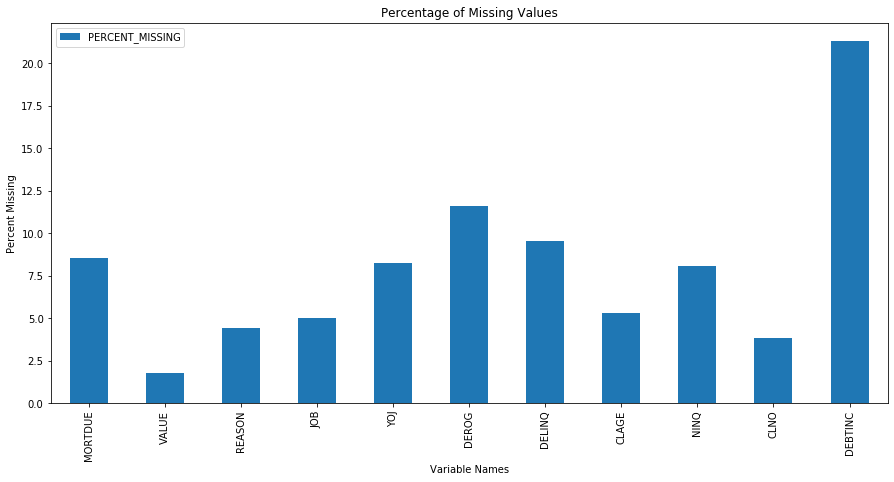

In [11]:
tbl_data_card['PERCENT_MISSING'] = (tbl_data_card['_NMISS_'] / tbl_data_card['_NOBS_']) * 100

ax = tbl_data_card[['_VARNAME_', 'PERCENT_MISSING']].to_frame().set_index('_VARNAME_').plot.bar(
         title='Percentage of Missing Values', figsize=(15,7)
     )
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

#### Impute missing values

In [12]:
hmeq_prepped = sess.CASTable('hmeq_prepped', replace=True)

indata.datapreprocess.transform(
    casout=hmeq_prepped,
    copyallvars=True,
    outvarsnameglobalprefix='im',
    requestpackages=[
        {'impute': {'method': 'mean'}, 'inputs': ['clage']},
        {'impute': {'method': 'median'}, 'inputs': ['delinq']},
        {'impute': {'method': 'value', 'valuesInterval': [2]}, 'inputs': ['ninq']},
        {'impute': {'method': 'value', 'valuesInterval': [35.0, 7, 2]}, 'inputs': ['debtinc', 'yoj']}
    ]
)

[TransInfo]

 Transformation Requests for HMEQ_TRAIN
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           1         Mean
 1       _TR2           1       Median
 2       _TR3           1        Value
 3       _TR4           2        Value

[VarTransInfo]

 Variable Transformation Information for HMEQ_TRAIN
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             im    im_CLAGE  2255    126              178.606762
 1  DEBTINC             im  im_DEBTINC  1873    508               35.000000
 2   DELINQ             im   im_DELINQ  2153    228                0.000000
 3     NINQ             im     im_NINQ  2189    192                2.000000
 4      YOJ             im      im_YOJ  2184    197                7.000000

[OutputCasTables]

                 casLib          Name  Rows  Columns  \
 0  CASUSER(viyademo01)  hmeq_prepped  2381       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyad...  

+ Elapsed: 0.0268s, user: 0.0223s, sys: 0.0191s, mem: 71mb

## Partition data into Training and Validation

The stratified action in the sampling actionset allows us to create two partition and observe the reponse rate of the target variable `bad` in both training and validation

In [27]:
hmeq_part = sess.CASTable('hmeq_part', replace=True)

hmeq_prepped.groupby(target).sampling.stratified(
  output=dict(casout=hmeq_part, copyvars='all'),
  samppct=70,
  partind=True
)

NOTE: Stratified sampling is in effect.
NOTE: Using SEED=786930346 for sampling.


[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  1905   1334
 1        1             1   476    333

[OutputCasTables]

                 casLib       Name Label  Rows  Columns  \
 0  CASUSER(viyademo01)  hmeq_part        2381       19   
 
                                             casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(viyademo...  

+ Elapsed: 0.0282s, user: 0.0131s, sys: 0.0204s, mem: 41.3mb

## Decision Tree

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `tree_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `tree_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [28]:
hmeq_part_1 = hmeq_part.query('_partind_ = 1')
tree_model = sess.CASTable('tree_model', replace=True)
scored_tree = sess.CASTable('_scored_tree', replace=True)

hmeq_part_1.decisiontree.dtreetrain(
  inputs=all_inputs,
  target='bad',
  nominals=class_vars,
  crit='gain',
  prune=True,
  varImp=True,
  missing='useinsearch',
  casout=tree_model
)

# Score 
hmeq_part.decisiontree.dtreescore(
  modeltable=tree_model,
  casout=scored_tree,
  copyvars=['bad', '_partind_']
)

# Create p_bad0 and p_bad1 as _dt_predp_ is the probability of event in _dt_predname_
scored_tree['p_bad1'] = scored_tree.eval("ifn( strip(_dt_predname_) = '1', _dt_predp_, 1-_dt_predp_ )") 
scored_tree['p_bad0'] = scored_tree.eval("ifn( strip(_dt_predname_) = '0', 1-_dt_predp_, _dt_predp_ )")

## Decision Forest

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `forest_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `forest_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [29]:
forest_model = sess.CASTable('forest_model', replace=True)
scored_rf = sess.CASTable('_scored_rf', replace=True)

hmeq_part_1.decisiontree.foresttrain(
  inputs=all_inputs,
  nominals=class_vars,
  target='bad',
  ntree=50,
  nbins=20,
  leafsize=5,
  maxlevel=21,
  crit='gainratio',
  varimp=True,
  missing='useinsearch',
  vote='prob',
  casout=forest_model,
  savestate={'name':'foreststate'}
)

# Score 
hmeq_part.decisiontree.forestscore(
  modeltable=forest_model,
  casout=scored_rf,
  copyvars=['bad', '_partind_'],
  vote='prob'
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
scored_rf['p_bad1'] = scored_rf.eval("ifn( strip(_rf_predname_) = '1', _rf_predp_, 1-_rf_predp_ )") 
scored_rf['p_bad0'] = scored_rf.eval("ifn( strip(_rf_predname_) = '0', 1-_rf_predp_, _rf_predp_ )")

NOTE: 5960014 bytes were written to the table "foreststate" in the caslib "CASUSER(viyademo01)".


## Gradient Boosting Machine


In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `gb_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `gb_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [30]:
gb_model = sess.CASTable('gb_model', replace=True)
scored_gb = sess.CASTable('_scored_gb', replace=True)

hmeq_part_1.decisiontree.gbtreetrain(
  inputs=all_inputs,
  nominals=class_vars,
  target=target,
  ntree=10,
  nbins=20,
  maxlevel=6,
  varimp=True,
  missing='useinsearch',
  casout=gb_model
)

# Score 
hmeq_part.decisionTree.gbtreeScore(
  modeltable=gb_model,
  casout=scored_gb,
  copyvars=[target, '_partind_']
)

# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
scored_gb['p_bad1'] = scored_gb.eval("ifn( strip(_gbt_predname_) = '1', _gbt_predp_, 1-_gbt_predp_ )") 
scored_gb['p_bad0'] = scored_gb.eval("ifn( strip(_gbt_predname_) = '0', 1-_gbt_predp_, _gbt_predp_ )")

## Neural Network

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `nnet_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `nnet_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [31]:
hmeq_part_0 = hmeq_part.query('_partind_ = 0')
nnet_model = sess.CASTable('nnet_model', replace=True)
scored_nn = sess.CASTable('_scored_nn', replace=True)

hmeq_part_1.neuralnet.anntrain(
  validtable=hmeq_part_0,
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  hiddens={9},
  acts=['tanh'],
  combs=['linear'],
  targetact='softmax',
  errorfunc='entropy',
  std='midrange',
  randdist='uniform',
  scaleinit=1,
  nloopts={
      'optmlopt': {'maxiters': 250, 'fconv': 1e-10}, 
      'lbfgsopt': {'numcorrections': 6},
      'printopt': {'printlevel': 'printdetail'},
      'validate': {'frequency': 1}
  },
  casout=nnet_model
)

# Score 
hmeq_part.neuralnet.annscore(
  modeltable=nnet_model,
  casout=scored_nn,
  copyvars=['bad', '_partind_']
)

# Create p_bad0 and p_bad1 as _nn_predp_ is the probability of event in _nn_predname_
scored_nn['p_bad1'] = scored_nn.eval("ifn( strip(_nn_predname_) = '1', _nn_predp_, 1-_nn_predp_ )") 
scored_nn['p_bad0'] = scored_nn.eval("ifn( strip(_nn_predname_) = '0', 1-_nn_predp_, _nn_predp_ )")

## Assess Models

In [32]:
def assess_model(t):
    return sess.percentile.assess(
               table=t.query('_partind_ = 0'),
               inputs=['p_bad1'],      
               response='bad',
               event='1',
               pvar=['p_bad0'],
               pevent=['0']      
           )

tree_assess   = assess_model(scored_tree)    
tree_fitstat  = tree_assess.FitStat
tree_rocinfo  = tree_assess.ROCInfo
tree_liftinfo = tree_assess.LIFTInfo

rf_assess   = assess_model(scored_rf)    
rf_fitstat  = rf_assess.FitStat
rf_rocinfo  = rf_assess.ROCInfo
rf_liftinfo = rf_assess.LIFTInfo

gb_assess   = assess_model(scored_gb)    
gb_fitstat  = gb_assess.FitStat
gb_rocinfo  = gb_assess.ROCInfo
gb_liftinfo = gb_assess.LIFTInfo

nn_assess   = assess_model(scored_nn)    
nn_fitstat  = nn_assess.FitStat
nn_rocinfo  = nn_assess.ROCInfo
nn_liftinfo = nn_assess.LIFTInfo

## Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [33]:
# Add new variable to indicate type of model
tree_liftinfo['model'] = 'DecisionTree'
tree_rocinfo['model']  = 'DecisionTree'
rf_liftinfo['model']   = 'Forest'
rf_rocinfo['model']    = 'Forest'
gb_liftinfo['model']   = 'GradientBoosting'
gb_rocinfo['model']    = 'GradientBoosting'
nn_liftinfo['model']   = 'NeuralNetwork'
nn_rocinfo['model']    = 'NeuralNetwork'

# Concatenate data
all_liftinfo = pd.concat([rf_liftinfo, gb_liftinfo, nn_liftinfo, tree_liftinfo], ignore_index=True)
all_rocinfo = pd.concat([rf_rocinfo, gb_rocinfo, nn_rocinfo, tree_rocinfo], ignore_index=True)

## Print AUC (Area Under the ROC Curve)

In [34]:
all_rocinfo[['model', 'C']].drop_duplicates(keep='first').sort_values(by='C', ascending=False)

,model,C
0,Forest,0.906464
100,GradientBoosting,0.890420
300,DecisionTree,0.856509
200,NeuralNetwork,0.783887


## Draw ROC and Lift plots

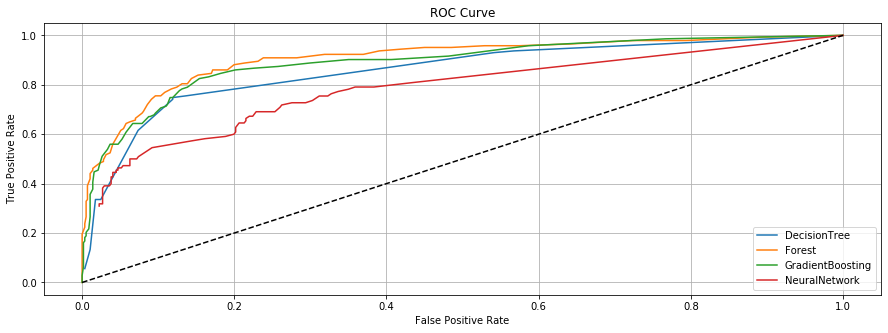

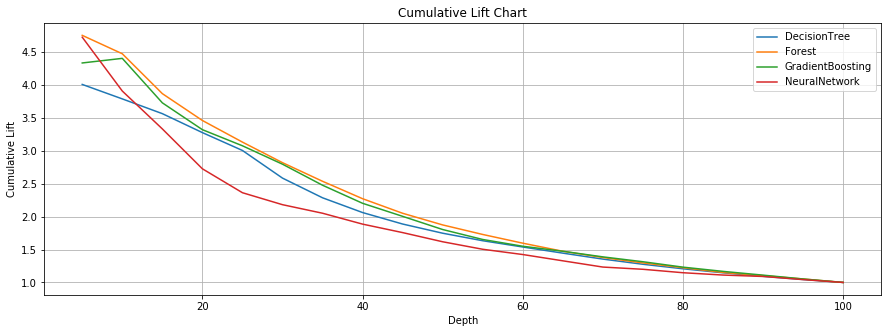

In [35]:
# Draw ROC charts 
plt.figure(figsize=(15, 5))
for key, grp in all_rocinfo.groupby(['model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label=key)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

# Draw lift charts
plt.figure(figsize=(15, 5))
for key, grp in all_liftinfo.groupby(['model']):
    plt.plot(grp['Depth'], grp['CumLift'], label=key)
plt.xlabel('Depth')
plt.ylabel('Cumulative Lift')
plt.grid(True)
plt.legend(loc='best')
plt.title('Cumulative Lift Chart')
plt.show();

# Register Model

## Add model to repository - CAS

In [36]:
from sasctl import Session
from sasctl.tasks import register_model
from sasctl.services import model_repository

astore = sess.CASTable('foreststate')

with Session('http://frasepviya35smp', 'viyademo01', password):
    register_model(astore, 'Forest Model using Python swat', 'QS_HMEQ')

NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _DB176F1808CD4EEDB758CFE1D.sashdat in caslib ModelStore.


## End CAS session

This closes the CAS session freeing resources for others to leverage

In [13]:
# This is the same as sess.endsession(); sess.close();
sess.terminate()